# 📦 EDA de E-commerce (Olist)

Este notebook realiza uma **Análise Exploratória** com foco em **insights de marketing** e prepara **tabelas para um dashboard Streamlit**.

**Roteiro**
1. Carregamento e dicionário de dados  
2. Base consolidada (orders + payments + customers)  
3. KPIs e Geografia (ticket por UF)  
4. Produtos/Categorias (faturamento aproximado)  
5. Entrega × Satisfação (atraso vs. review)  
6. RFM (Recency, Frequency, Monetary) + segmentos  
7. Exportações e insights finais


# Descrição dos datasets
- **df_customers**: dataset contendo informações sobre os consumidores e sua localização. Colunas:
    - **customer_id** (*UUID*): identifica cada pedido de um consumidor com um id unico.
    - **customer_unique_id** (*UUID*): identifica cada consumidor com um id único.
    - **customer_zip_code_prefix** (*int*): primeiros 5 dígitos CEP da localização de entrega do consumidor.
    - **customer_city** (*str*): cidade do consumidor.
    - **customer_state** (*str*): estado do consumidor.

- **df_orders**: dataset contendo as informações sobre o pedido. Colunas:
    - **order_id** (*UUID*): identifica cada pedido com um código único.
    - **customer_id** (*UUID*): chave que conecta ao dataset **df_costumers** com um id único por pedido.
    - **order_status** (*string*): status do pedido.
    - **order_purchase_timestamp** (*datetime*): data e hora da compra.
    - **order_approved_at** (*datetime*): data e hora de aprovação do pagamento.
    - **order_delivered_carrier_date** (*datetime*): data e hora de postagem da ordem.
    - **order_delivered_customer_date** (*datetime*): data e hora real da entrega ao cliente.
    - **order_estimated_delivery_date** (*datetime*): data e hora estimada de entrega.

- **df_items**: dataset contendo informações sobre os items de cada pedido. Colunas:
    - **order_id** (*UUID*): chave que conecta ao **df_orders** através de um id único por ordem.
    - **order_item_id** (*int*): identifica unicamente cada item dentro de uma ordem.
    - **product_id** (*UUID*): identifica cada produto por meio de um id único.
    - **seller_id** (*UUID*): id único de vendedor.
    - **shipping_limit_date** (*datetime*): data limite para enviar o pedido.
    - **price** (*float*): preço do item.
    - **freight** (*float*): valor do frete do item.

- **df_products**: dataset que contém informações sobre cada produto vendido por Olist. Colunas:
    - **product_id** (*UUID*): id único do produto.
    - **product_category_name** (*string*): nome da categoria a qual o produto pertence.
    - **product_name_length** (*int*): número de caracteres extraídos do nome do produto.
    - **product_description_length** (*int*): número de caracteres extraídos da descrição do produto.
    - **product_photos_qty** (*int*): número de fotos publicadas do produto.
    - **product_weight_g** (*float*): peso do produto medido em gramas.
    - **product_length_cm** (*float*): comprimento do produto medido em centímetros.
    - **product_height_cm** (*float*): altura do produto medida em centímetros.
    - **product_width_cm** (*float*): largura do produto medida em centímetros.

- **df_reviews**: dataset contendo informações sobre os reviews feitas pelos clientes. Colunas:
    - **review_id** (*UUID*): identificador único de cada review.
    - **order_id** (*UUID*): identificador único de cada ordem, conectando ao dataset **df_orders**.
    - **review_score** (*int*): nota variando de 1 a 5 dada pelo cliente em uma pesquisa de satisfação.
    - **review_comment_title** (*string*): título do comentário deixado pelo cliente na review.
    - **review_comment_message** (*string*): mensagem do comentário deixado pelo cliente na review.
    - **review_creation_date** (*datetime*): data em que a pesquisa de satisfação foi enviada ao cliente.
    - **review_answer_timestamp** (*datetime*): data e hora em que foi respondida a pesquisa de satisfação pelo usuário.

- **df_payments**: dataset que contém informações das opções de pagamento dos pedidos. Colunas:
    - **order_id** (*UUID*): identificador único da ordem.
    - **payment_sequential** (*int*): número sequencial que identifica cada método de pagamento utilizado
    por um cliente quando separa o valor em mais de um método de pagamento.
    - **payment_type** (*string*): forma de pagamento utilizada.
    - **payment_installments** (*int*): número de parcelas escolhido pelo cliente.
    - **payment_value** (*float*): valor da transação.

- **df_sellers**: dataset que contém informações sobre vendedores de produtos da Olist. Colunas:
    - **seller_id** (*UUID*): identificador único do vendedor.
    - **seller_zip_code_prefix** (*int*): primeiros 5 dígitos do CEP do vendedor.
    - **seller_city** (*string*): cidade do vendedor.
    - **seller_state** (*string*): estado do vendedor.

- **df_geolocations**: dataset contendo informações de localização sobre CEPs brasileiros. Colunas:
    - **geolocation_zip_code_prefix** (*int*): primeiros 5 dígitos do CEP.
    - **geolocation_lat** (*float*): latitude em que o CEP se encontra.
    - **geolocation_lng** (*float*): longitude em que o CEP se encontra.
    - **geolocation_city** (*string*): nome da cidade a qual o CEP pertence.
    - **geolocation_state** (*string*): sigla do estado que o CEP pertence.

## 0) Imports e configuração

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import timedelta
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

## 1) Caminhos e carregamento de dados

In [3]:
DATA_DIR = Path("data")
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# CSVs essenciais
df_orders    = pd.read_csv(DATA_DIR / "olist_orders_dataset.csv")
df_payments  = pd.read_csv(DATA_DIR / "olist_order_payments_dataset.csv")
df_customers = pd.read_csv(DATA_DIR / "olist_customers_dataset.csv")

# CSVs opcionais
df_items, df_products, df_reviews = None, None, None
try:
    df_items     = pd.read_csv(DATA_DIR / "olist_order_items_dataset.csv")
    df_products  = pd.read_csv(DATA_DIR / "olist_products_dataset.csv")
except Exception:
    pass

try:
    df_reviews   = pd.read_csv(DATA_DIR / "olist_order_reviews_dataset.csv")
except Exception:
    pass

try:
    df_geolocations   = pd.read_csv(DATA_DIR / "olist_geolocation_dataset.csv")
except Exception:
    pass

print("✅ Dados carregados.")
print("orders:", df_orders.shape, "| payments:", df_payments.shape, "| customers:", df_customers.shape)
if df_items is not None and df_products is not None:
    print("items:", df_items.shape, "| products:", df_products.shape)
if df_reviews is not None:
    print("reviews:", df_reviews.shape)

if df_geolocations is not None:
    print("geolocations:", df_geolocations.shape)

✅ Dados carregados.
orders: (99441, 8) | payments: (103886, 5) | customers: (99441, 5)
items: (112650, 7) | products: (32951, 9)
reviews: (99224, 7)
geolocations: (1000163, 5)


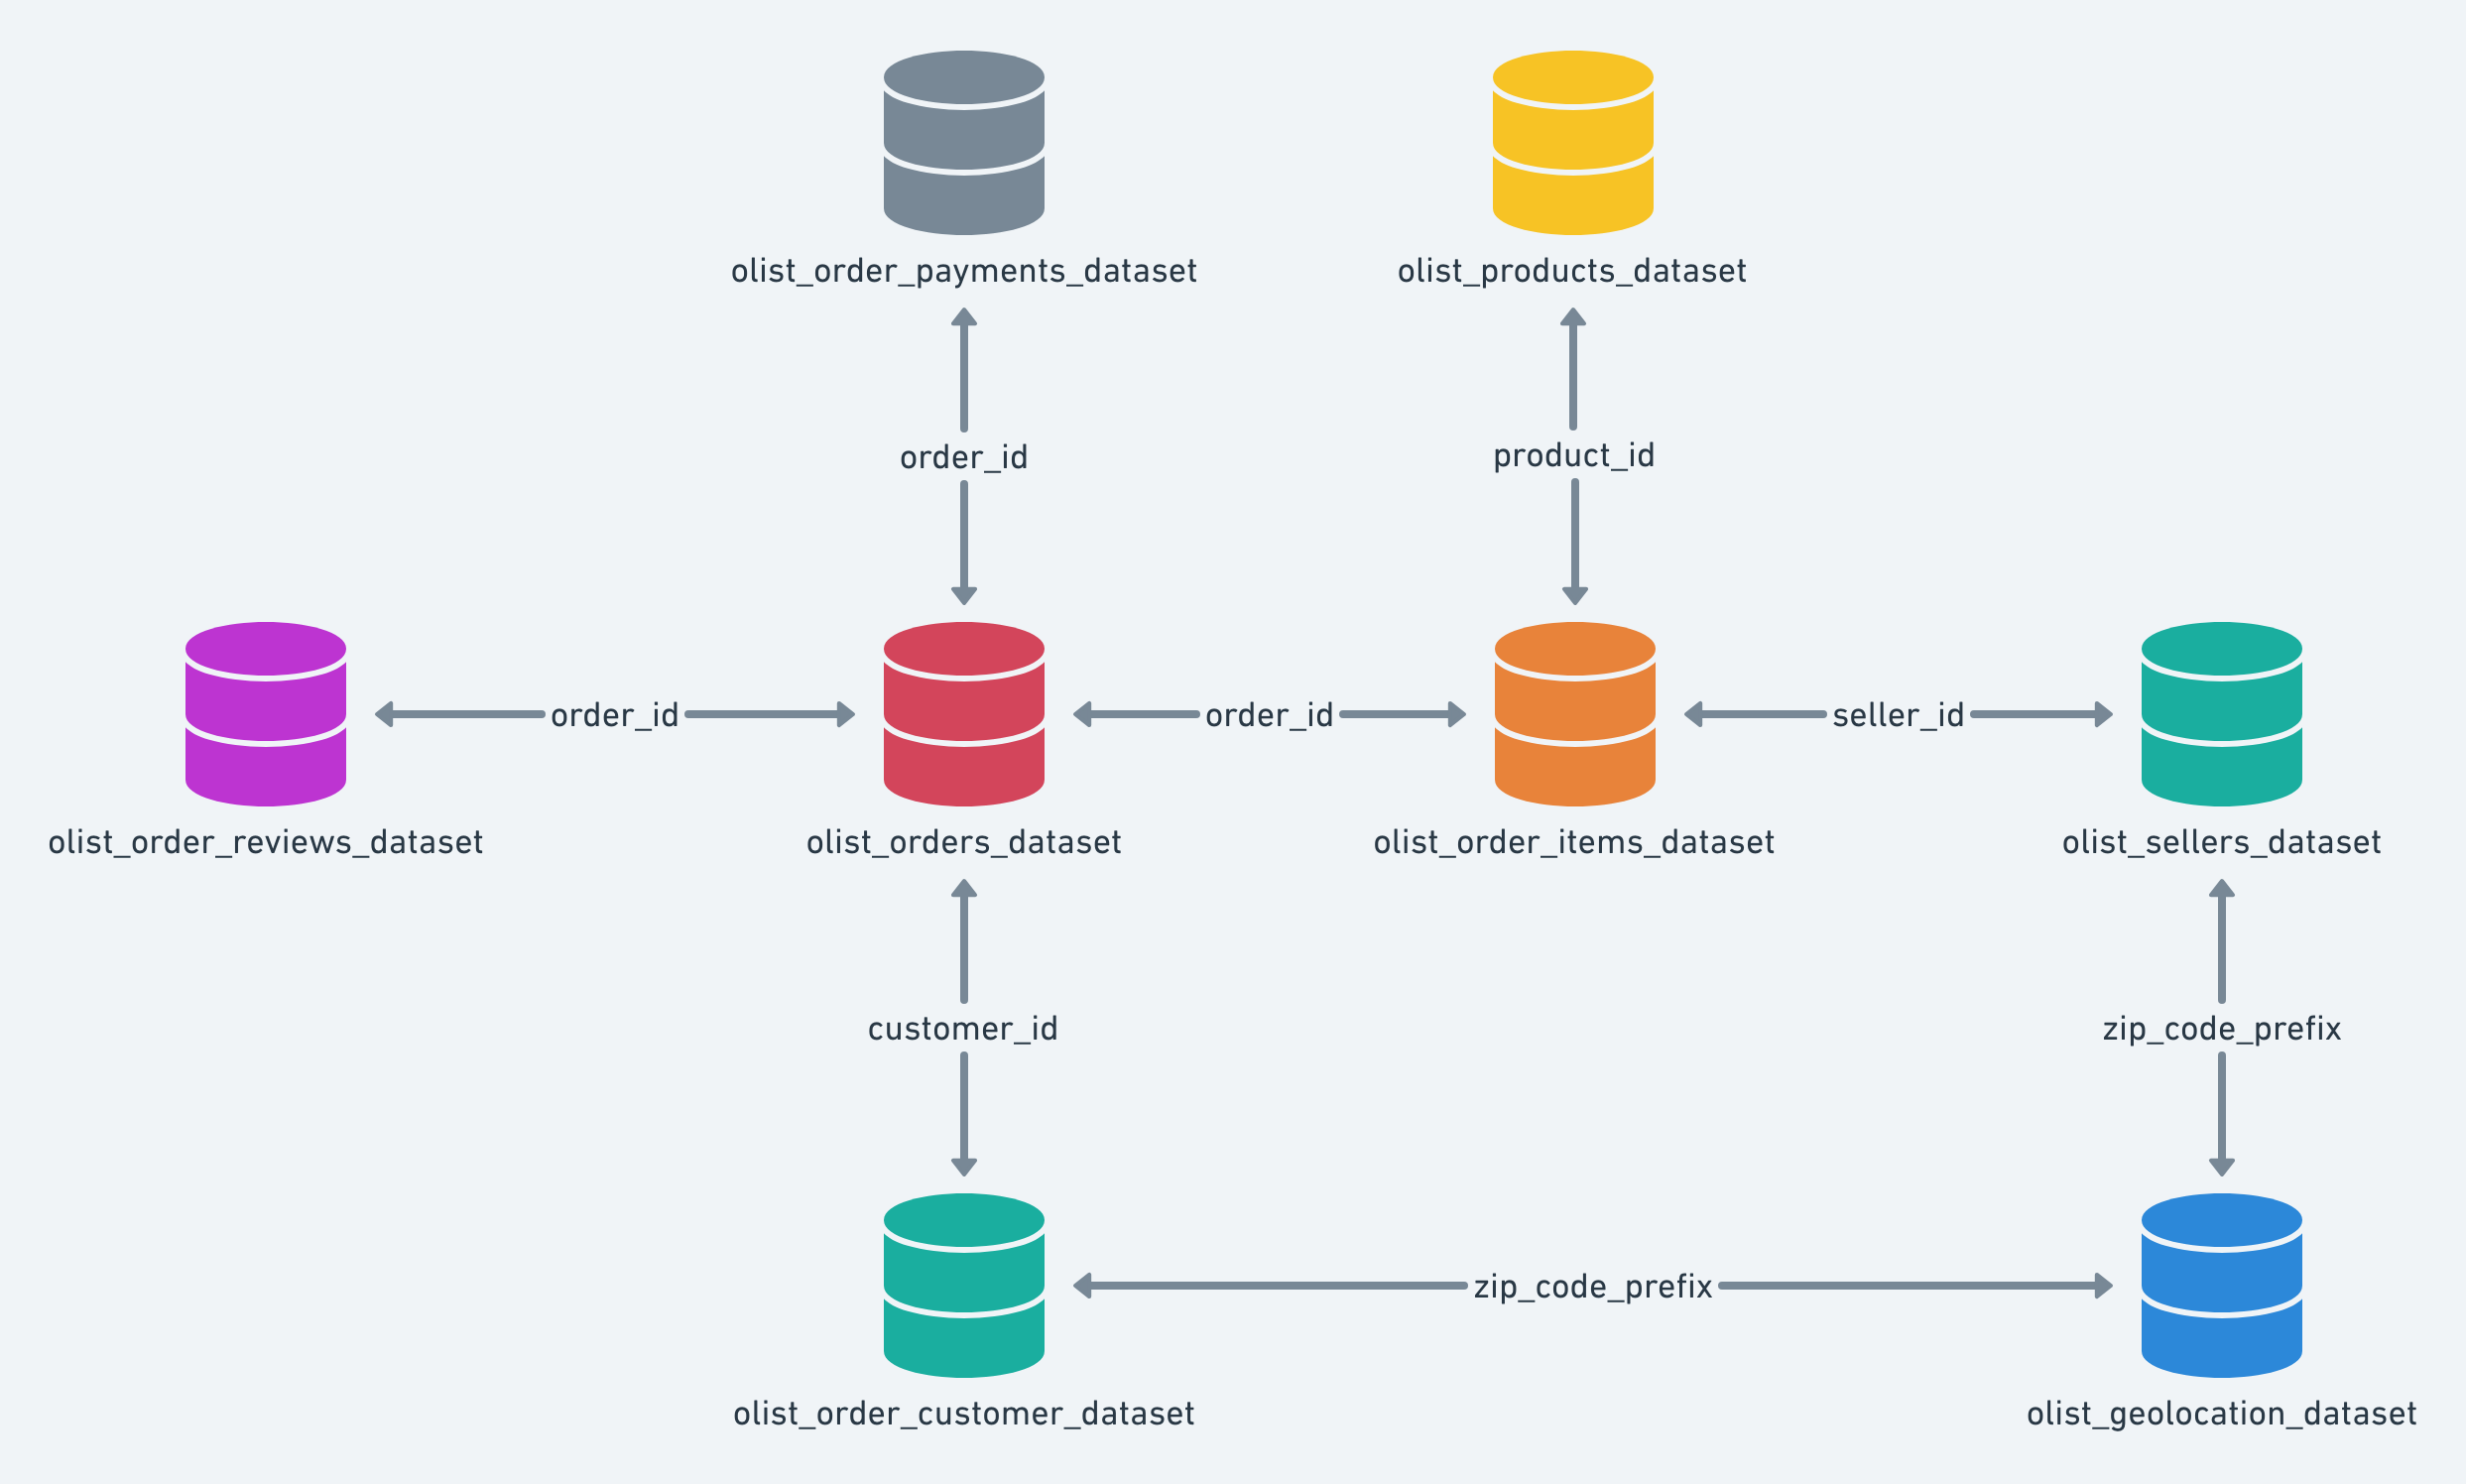

## 2) Base consolidada (orders + payments + customers)

In [7]:
pay_agg = (
    df_payments
    .groupby("order_id", as_index=False)
    .agg(payment_value=("payment_value","sum"),
         payment_types=("payment_type", lambda x: list(x)))
)

df_base = (
    df_orders
    .merge(pay_agg, on="order_id", how="left")
    .merge(
        df_customers[["customer_id","customer_unique_id","customer_city","customer_state"]],
        on="customer_id", how="left"
    )
)

date_cols = [
    "order_purchase_timestamp","order_approved_at",
    "order_delivered_carrier_date","order_delivered_customer_date",
    "order_estimated_delivery_date"
]
for c in date_cols:
    if c in df_base.columns:
        df_base[c] = pd.to_datetime(df_base[c], errors="coerce")

print("✅ Base consolidada:", df_base.shape)
display(df_base.head(3))

✅ Base consolidada: (99441, 13)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value,payment_types,customer_unique_id,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,38.71,"[credit_card, voucher, voucher]",7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,141.46,[boleto],af07308b275d755c9edb36a90c618231,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,179.12,[credit_card],3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO


## 3) KPIs e Geografia (ticket médio por UF)

Métricas básicas e **ticket médio (faturamento / nº de pedidos)** por estado (UF). Isso ajuda a enxergar onde estão os clientes de **alto valor por pedido**.


In [9]:
tot_pedidos = df_base["order_id"].nunique()
faturamento = df_base["payment_value"].sum()
ticket_medio = faturamento / tot_pedidos if tot_pedidos else 0

print("\n=== KPIs ===")
print(f"Pedidos: {tot_pedidos:,}".replace(",", "."))
print(f"Faturamento: R$ {faturamento:,.2f}".replace(",", "X").replace(".", ",").replace("X","."))
print(f"Ticket Médio: R$ {ticket_medio:,.2f}".replace(",", "X").replace(".", ",").replace("X","."))



=== KPIs ===
Pedidos: 99.441
Faturamento: R$ 16.008.872,12
Ticket Médio: R$ 160,99


In [10]:
ticket_por_estado = (
    df_base.groupby("customer_state", as_index=False)
    .agg(pedidos=("order_id","nunique"),
         faturamento=("payment_value","sum"))
)
ticket_por_estado["ticket_medio"] = ticket_por_estado["faturamento"] / ticket_por_estado["pedidos"]
ticket_por_estado = ticket_por_estado.sort_values("ticket_medio", ascending=False)

print("\nTop 10 ticket por UF:")
print(ticket_por_estado.head(10))


Top 10 ticket por UF:
   customer_state  pedidos  faturamento  ticket_medio
14             PB      536    141545.72    264.077836
0              AC       81     19680.62    242.970617
20             RO      253     60866.20    240.577866
3              AP       68     16262.80    239.158824
1              AL      413     96962.06    234.774964
13             PA      975    218295.85    223.893179
26             TO      280     61485.33    219.590464
16             PI      495    108523.97    219.240343
21             RR       46     10064.62    218.796087
24             SE      350     75246.25    214.989286


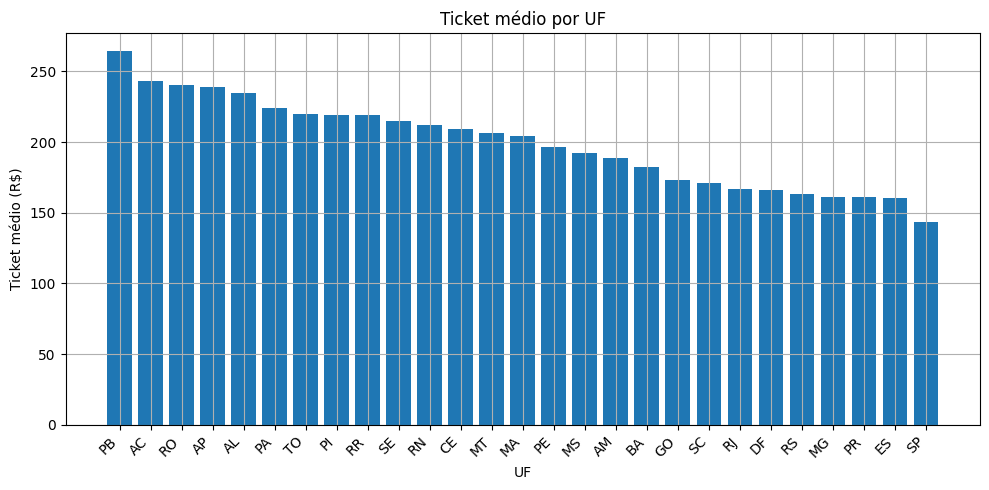

In [11]:
plt.figure()
plt.bar(ticket_por_estado["customer_state"], ticket_por_estado["ticket_medio"])
plt.title("Ticket médio por UF")
plt.xlabel("UF")
plt.ylabel("Ticket médio (R$)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(OUT_DIR / "ticket_por_uf.png", dpi=150)
plt.show()

## 4) Produtos/Categorias (faturamento aproximado)


Top 15 categorias por faturamento (aprox):
     product_category_name  faturamento  pedidos
11            beleza_saude   1441248.07     8836
66      relogios_presentes   1305541.61     5624
13         cama_mesa_banho   1241681.72     9417
32           esporte_lazer   1156656.48     7720
44  informatica_acessorios   1059272.40     6689
54        moveis_decoracao    902511.79     6449
72   utilidades_domesticas    778397.77     5884
26              cool_stuff    719329.95     3632
8               automotivo    685384.32     3897
40      ferramentas_jardim    584219.21     3518
12              brinquedos    561372.55     3886
9                    bebes    480118.00     2885
62              perfumaria    453338.71     3162
70               telefonia    394883.32     4199
55       moveis_escritorio    342532.65     1273


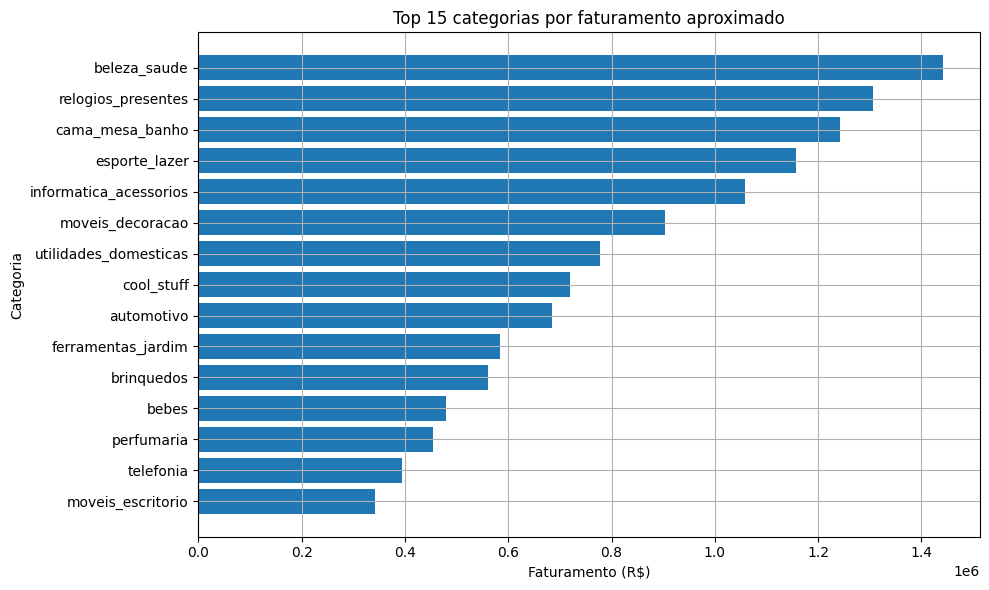

In [13]:
fat_cat = pd.DataFrame()
if (df_items is not None) and (df_products is not None):
    df_ip = df_items.merge(df_products, on="product_id", how="left")
    df_ip["revenue_item"] = df_ip["price"].fillna(0) + df_ip["freight_value"].fillna(0)

    keep_orders = df_base[["order_id"]].drop_duplicates()
    df_ip = df_ip.merge(keep_orders, on="order_id", how="inner")

    fat_cat = (
        df_ip.groupby("product_category_name", as_index=False)
        .agg(faturamento=("revenue_item","sum"),
             pedidos=("order_id","nunique"))
        .sort_values("faturamento", ascending=False)
    )
    print("\nTop 15 categorias por faturamento (aprox):")
    print(fat_cat.head(15))
    top = fat_cat.head(15)
    plt.figure(figsize=(10,6))
    plt.barh(top["product_category_name"], top["faturamento"])
    plt.title("Top 15 categorias por faturamento aproximado")
    plt.xlabel("Faturamento (R$)")
    plt.ylabel("Categoria")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(OUT_DIR / "top_categorias.png", dpi=150)
    plt.show()
else:
    print("\nItens/Produtos não carregados — pulando seção de categorias.")

## 5) Entrega × Satisfação (atraso vs. review)

### 1.2) Merge dos datasets gerando apenas um


Atraso x Review (médias):
   review_score  delay_medio    qtd
0           1.0    -4.060580   9409
1           2.0    -8.634818   2941
2           3.0   -10.774052   7962
3           4.0   -12.380840  18987
4           5.0   -13.388153  57060


/tmp/ipykernel_17172/473375124.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[int(s) for s in scores], showfliers=False)


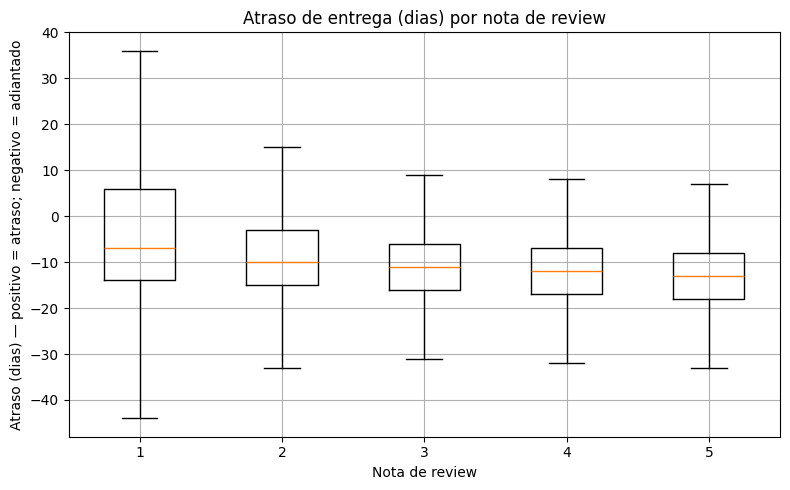

In [14]:
rel = pd.DataFrame()
if df_reviews is not None:
    df_tmp = df_base[["order_id","order_delivered_customer_date","order_estimated_delivery_date"]].copy()
    for c in ["order_delivered_customer_date","order_estimated_delivery_date"]:
        df_tmp[c] = pd.to_datetime(df_tmp[c], errors="coerce")

    df_tmp["delivery_delay_days"] = (df_tmp["order_delivered_customer_date"] - df_tmp["order_estimated_delivery_date"]).dt.days

    df_rev = df_reviews[["order_id","review_score"]].copy()
    df_rev["review_score"] = pd.to_numeric(df_rev["review_score"], errors="coerce")

    df_delay_review = df_tmp.merge(df_rev, on="order_id", how="left")

    rel = (
        df_delay_review.dropna(subset=["review_score","delivery_delay_days"])
        .groupby("review_score", as_index=False)
        .agg(delay_medio=("delivery_delay_days","mean"),
             qtd=("order_id","count"))
        .sort_values("review_score")
    )
    print("\nAtraso x Review (médias):")
    print(rel)

    # Boxplot (sem outliers visuais)
    scores = sorted(df_delay_review["review_score"].dropna().unique())
    data = [df_delay_review.loc[df_delay_review["review_score"]==s, "delivery_delay_days"].dropna() for s in scores]
    plt.figure(figsize=(8,5))
    plt.boxplot(data, labels=[int(s) for s in scores], showfliers=False)
    plt.title("Atraso de entrega (dias) por nota de review")
    plt.xlabel("Nota de review")
    plt.ylabel("Atraso (dias) — positivo = atraso; negativo = adiantado")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "atraso_por_review.png", dpi=150)
    # plt.show()
else:
    print("\nReviews não carregados — pulando seção de satisfação.")


## 6) RFM (Recency, Frequency, Monetary) + Segmentos

In [15]:
orders_totals = (
    df_base.groupby(["order_id","customer_unique_id"], as_index=False)
    .agg(order_purchase_timestamp=("order_purchase_timestamp","max"),
         payment_value=("payment_value","sum"))
)

ref_date = orders_totals["order_purchase_timestamp"].max() + timedelta(days=1)

rfm = (
    orders_totals.groupby("customer_unique_id", as_index=False)
    .agg(Recency=("order_purchase_timestamp", lambda x: (ref_date - x.max()).days),
         Frequency=("order_id","nunique"),
         Monetary=("payment_value","sum"))
)

# Scores (quintis) — R invertida (quanto menor, melhor)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)

rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].sum(axis=1)
rfm["RFM_Code"]  = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)


def segment(row):
    if row["R_Score"]>=4 and row["F_Score"]>=4 and row["M_Score"]>=4:
        return "Campeões"
    if row["R_Score"]>=4 and row["F_Score"]>=4:
        return "Fiéis"
    if row["R_Score"]>=4 and row["M_Score"]>=4:
        return "Gastadores recentes"
    if row["R_Score"]<=2 and row["F_Score"]>=3:
        return "Em risco"
    if row["R_Score"]<=2 and row["F_Score"]<=2 and row["M_Score"]<=2:
        return "Perdidos"
    return "Outros"

rfm["Segment"] = rfm.apply(segment, axis=1)

print("\nRFM (amostra):")
print(rfm.head())
print("\nDistribuição por segmento:")
print(rfm["Segment"].value_counts())


RFM (amostra):
                 customer_unique_id  Recency  Frequency  Monetary  R_Score  \
0  0000366f3b9a7992bf8c76cfdf3221e2      161          1    141.90        4   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      164          1     27.19        4   
2  0000f46a3911fa3c0805444483337064      586          1     86.22        1   
3  0000f6ccb0745a6a4b88665a16c9f078      370          1     43.62        2   
4  0004aac84e0df4da2b147fca70cf8255      337          1    196.89        2   

   F_Score  M_Score  RFM_Score RFM_Code              Segment  
0        1        4          9      414  Gastadores recentes  
1        1        1          6      411               Outros  
2        1        2          4      112             Perdidos  
3        1        1          4      211             Perdidos  
4        1        4          7      214               Outros  

Distribuição por segmento:
Segment
Outros                 41977
Em risco               22967
Gastadores recentes     9199
Fiéis         

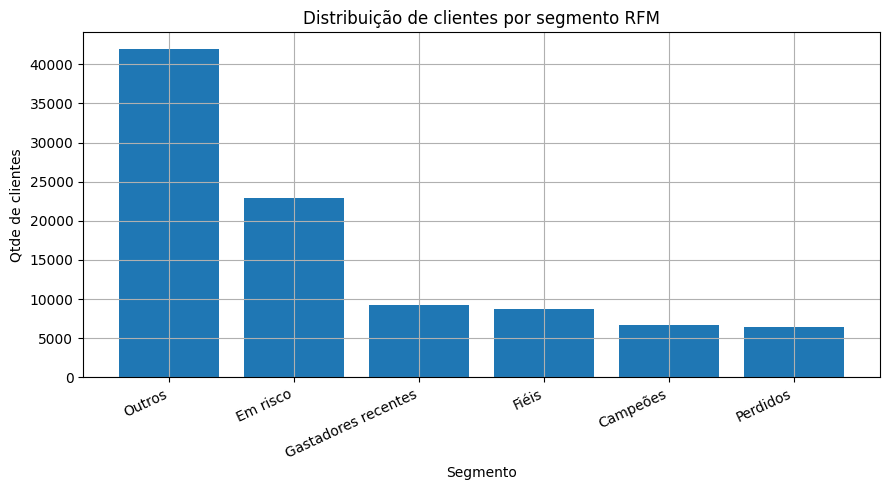

In [16]:
# Gráfico simples da distribuição por segmento
seg_counts = rfm["Segment"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(9,5))
plt.bar(seg_counts.index, seg_counts.values)
plt.title("Distribuição de clientes por segmento RFM")
plt.xlabel("Segmento")
plt.ylabel("Qtde de clientes")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.savefig(OUT_DIR / "rfm_segmentos.png", dpi=150)
plt.show()

## 7) Exportações para o dashboard + insights

In [17]:
try:
    ticket_por_estado.to_csv(OUT_DIR / "ticket_por_estado.csv", index=False)
except Exception:
    pass

try:
    fat_cat.to_csv(OUT_DIR / "fat_cat.csv", index=False)
except Exception:
    pass

try:
    rfm.to_csv(OUT_DIR / "rfm_table.csv", index=False)
except Exception:
    pass

print("\n✅ CSVs exportados em 'outputs/' (ticket_por_estado.csv, fat_cat.csv, rfm_table.csv).")


✅ CSVs exportados em 'outputs/' (ticket_por_estado.csv, fat_cat.csv, rfm_table.csv).


In [18]:
insights = []
insights.append(f"📈 Pedidos: {tot_pedidos:,} | Faturamento: R$ {faturamento:,.2f} | Ticket: R$ {ticket_medio:,.2f}".replace(",", "X").replace(".", ",").replace("X","."))

if 'ticket_por_estado' in globals() and not ticket_por_estado.empty:
    top_uf = ticket_por_estado.iloc[0]
    worst_uf = ticket_por_estado.iloc[-1]
    gap = top_uf['ticket_medio'] - worst_uf['ticket_medio']
    insights.append(f"📍 Ticket mais alto: {top_uf['customer_state']} (R$ {top_uf['ticket_medio']:.2f}); gap vs. {worst_uf['customer_state']}: R$ {gap:.2f}")

if not fat_cat.empty:
    top_cat = fat_cat.iloc[0]
    insights.append(f"🛍️ Categoria líder (aprox): {top_cat['product_category_name']} (R$ {top_cat['faturamento']:.2f})")

if 'rel' in globals() and not rel.empty:
    best = rel.sort_values('review_score').iloc[-1]
    worst = rel.sort_values('review_score').iloc[0]
    insights.append(f"🚚 Atraso médio por nota: {int(worst['review_score'])} → {worst['delay_medio']:.1f} dias; {int(best['review_score'])} → {best['delay_medio']:.1f} dias")

if 'rfm' in globals() and not rfm.empty:
    seg = rfm['Segment'].value_counts()
    if not seg.empty:
        insights.append(f"🎯 Segmento mais numeroso: {seg.index[0]} ({seg.iloc[0]} clientes)")

print("\n=== Insights ===")
for line in insights:
    print("-", line)

print("\n✅ Fim. Imagens salvas em 'outputs/' e CSVs prontos para o dashboard.")


=== Insights ===
- 📈 Pedidos: 99.441 | Faturamento: R$ 16.008.872,12 | Ticket: R$ 160,99
- 📍 Ticket mais alto: PB (R$ 264.08); gap vs. SP: R$ 120.39
- 🛍️ Categoria líder (aprox): beleza_saude (R$ 1441248.07)
- 🚚 Atraso médio por nota: 1 → -4.1 dias; 5 → -13.4 dias
- 🎯 Segmento mais numeroso: Outros (41977 clientes)

✅ Fim. Imagens salvas em 'outputs/' e CSVs prontos para o dashboard.
